In [77]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import time
from torch.optim.lr_scheduler import StepLR
import sympy as sp

In [78]:
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")

In [79]:
loaded_data = torch.load('hold_data.pth')

x_values = loaded_data['x_values'].to(device)
y_values = loaded_data['y_values'].to(device)
derivatives = loaded_data['derivatives'].to(device)
params = loaded_data['param_values'].to(device)
functions = loaded_data['formulas']
symbols = loaded_data['symbols']
num_params = loaded_data['num_params'].to(device)
hessians = torch.load('hold_other.pth')['hessians'].to(device)


/tmp/ipykernel_1975991/1158532762.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_data = torch.load('hold_data.pth')
/tmp/ipykernel_1975991/1158532762.py:10: Futu

In [45]:
print(f"x_values: {x_values.shape}")
print(f"y_values: {y_values.shape}")
print(f"derivatives: {derivatives.shape}")
print(f"hessians: {hessians.shape}")
print(f"param_values: {params.shape}")
print(f"formulas: {len(functions)}")
print(f"symbols: {len(symbols)}")
print(f"num_params: {num_params.shape}")

x_values: torch.Size([100])
y_values: torch.Size([10000, 100])
derivatives: torch.Size([10000, 100, 5])
hessians: torch.Size([10000, 100, 25])
param_values: torch.Size([10000, 5])
formulas: 10
symbols: 10
num_params: torch.Size([10])


In [175]:
h = hessians.flatten(1,2)
d = derivatives.flatten(1,2)
d = F.pad(d, (0,h.shape[1]-d.shape[1]))
y = F.pad(y_values, (0,h.shape[1]-y_values.shape[1]))
full_data = torch.stack([h,d,y], dim=2)

In [186]:
class Multi_Func_Channels(nn.Module):
    def __init__(self, functions, num_params, x_data, input_channels, device):
        super().__init__()
        self.device = device
        self.functions = functions
        self.x_data = x_data
        self.input_channels = input_channels
        self.num_params = num_params
        self.max_params = 5 #max(num_params)
        self.total_params = sum(self.num_params)
        self.symbols = symbols
        self.epsilon = 1e-4

        self.hidden_x1 = nn.Sequential(
            nn.Conv1d(in_channels=self.input_channels, out_channels=8, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=8, out_channels=6, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=6, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(64)
        )

        self.hidden_xfc = nn.Sequential(
            nn.Linear(256, 64),
            nn.SELU(),
            nn.Linear(64, 32),
            nn.SELU(),
            nn.Linear(32, 20),
            nn.SELU(),
        )

        self.hidden_x2 = nn.Sequential(
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(16),
            nn.Conv1d(in_channels=4, out_channels=2, kernel_size=3),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(8),
            nn.Conv1d(in_channels=2, out_channels=2, kernel_size=3),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(4),
        )

        self.flatten_layer = nn.Flatten()

        self.hidden_embedding = nn.Sequential(
            nn.Linear(28, 128),
            nn.SELU(),
            nn.Linear(128, 64),
            nn.SELU(),
            nn.Linear(64, self.total_params),
        )

    def evaluate(self, params, index):
        symbols = self.symbols[index]
        formula = self.functions[index]
        x = self.x_data
        var_values = {symbols[j]: params[:, j] for j in range(len(symbols)-1)}
        eval_func = sp.lambdify(symbols, formula, modules="numpy")
        results = []
        for xi in x:
            var_values[symbols[-1]] = xi
            np_values = {str(sym): var_values[sym].detach().cpu().numpy() for sym in symbols}
            results.append(eval_func(**np_values))
        tensor_results = [torch.tensor(r, device=device) for r in results]
        return torch.stack(tensor_results, dim=1)
    
    def derivative(self, params, index):
        derivatives = torch.zeros((params.shape[0], self.x_data.shape[0], self.max_params))
        params_n = params.clone().detach().requires_grad_(True)
        for p in range(len(symbols[index])):
            plus = params_n.clone()
            minus = params_n.clone()
            plus[:,p] += self.epsilon
            forward_values = self.evaluate(plus, index)
            minus[:, p] -= self.epsilon
            backward_values = self.evaluate(minus, index)
            derivatives[:, :, p] = (forward_values - backward_values) / (2 * self.epsilon)
        return derivatives

    def hessian(self, params, index):
        hessians = torch.zeros((params.shape[0], self.x_data.shape[0], self.max_params, self.max_params))
        params_f = params.clone().detach().requires_grad_(True)
        for j in range(len(symbols[index])):
            for k in range(len(symbols[index])):
                plus_plus = params_f.clone()
                plus_minus = params_f.clone()
                minus_plus = params_f.clone()
                minus_minus = params_f.clone()

                plus_plus[:, j] += self.epsilon
                plus_plus[:, k] += self.epsilon

                plus_minus[:, j] += self.epsilon
                plus_minus[:, k] -= self.epsilon

                minus_plus[:, j] -= self.epsilon
                minus_plus[:, k] += self.epsilon

                minus_minus[:, j] -= self.epsilon
                minus_minus[:, k] -= self.epsilon

                forward_forward = self.evaluate(plus_plus, index)
                forward_backward = self.evaluate(plus_minus, index)
                backward_forward = self.evaluate(minus_plus, index)
                backward_backward = self.evaluate(minus_minus,index)
                hessians[:, :, j, k] = (forward_forward - forward_backward - backward_forward + backward_backward) / (4 * self.epsilon **2)
        return hessians
    
    def loss_func(self, outputs, targets):
        losses = []
        outputs = outputs.permute(2,0,1)
        targets = targets.permute(2,0,1)
        for output, target in zip(outputs, targets):
            loss = torch.mean((torch.abs(target - output) ** 2), dim=1)
            losses.append(loss)
        total_losses = torch.mean(torch.stack(losses), dim=0)
        #l2_reg = sum(p.pow(2.0).sum() for p in self.parameters())
        #l1_reg = sum(p.abs().sum() for p in self.parameters())
        #total_losses += 0.01 * l2_reg + 0.01 * l1_reg
        return total_losses

    def forward(self, inputs):
        target = inputs.squeeze(dim=2)
        outs = torch.swapaxes(inputs, 1, 2).to(self.device)
        outs = self.hidden_x1(outs)
        xfc = torch.reshape(outs, (-1, 256))
        xfc = self.hidden_xfc(xfc)

        outs = torch.reshape(outs, (-1, 2, 128))
        outs = self.hidden_x2(outs)
        cnn_flat = self.flatten_layer(outs)
        encoded = torch.cat((cnn_flat, xfc), 1)
        embedding = self.hidden_embedding(encoded)

        start_index = 0
        losses = []
        outputs = []
        preds = []

        for f in range(len(self.functions)):
            params = embedding[:, start_index:start_index+self.num_params[f]]
            y_vals = self.evaluate(params, f).to(self.device)
            d_vals = self.derivative(params, f).to(self.device)
            h_vals = self.hessian(params, f).to(self.device)
            h_vals = h_vals.flatten(1,3)
            d_vals = d_vals.flatten(1,2)
            d_vals = F.pad(d_vals, (0,h_vals.shape[1]-d_vals.shape[1]))
            y_vals = F.pad(y_vals, (0,h_vals.shape[1]-y_vals.shape[1]))
            output = torch.stack([h_vals,d_vals,y_vals], dim=2)
            outputs.append(output)
            preds.append(y_vals)
            loss = self.loss_func(output, target)
            losses.append(loss)
            start_index += self.num_params[f]       
        stacked_losses = torch.stack(losses).to(self.device)
        stacked_preds = torch.stack(preds).to(self.device)
        best_loss, best_indexes = torch.min(stacked_losses, dim=0)
        best_out = stacked_preds[best_indexes, -1]
        best_func = [self.functions[idx] for idx in best_indexes]
        return best_out, best_loss, best_func, stacked_preds, stacked_losses

In [212]:
def training_loss_func(model, output, target):
    target_max = torch.max(target, dim=-1, keepdim=True)[0]
    target_min = torch.min(target, dim=-1, keepdim=True)[0]
    target_range = torch.clamp(target_max - target_min, min=1e-6).squeeze(-1)
    
    #mse_loss = torch.mean((output - target) ** 2, dim=-1)
    loss = torch.mean((torch.abs(target - output) ** 2), dim=1)
    #normalized_loss = mse_loss / target_range
    
    #l2_reg = sum(p.pow(2.0).sum() for p in model.parameters())
    #l1_reg = sum(p.abs().sum() for p in model.parameters())    
    #total_loss = torch.mean(normalized_loss) + 0.01 * l2_reg + 0.01 * l1_reg
    return torch.mean(loss)


tensor(1.0664, device='cuda:4', grad_fn=<SelectBackward0>)
tensor([-2947.1396, -3007.9055, -3071.2297,  ...,     0.0000,     0.0000,
            0.0000], device='cuda:4')
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:4',
       grad_fn=<SelectBackward0>)
loss: 91795648151552.0


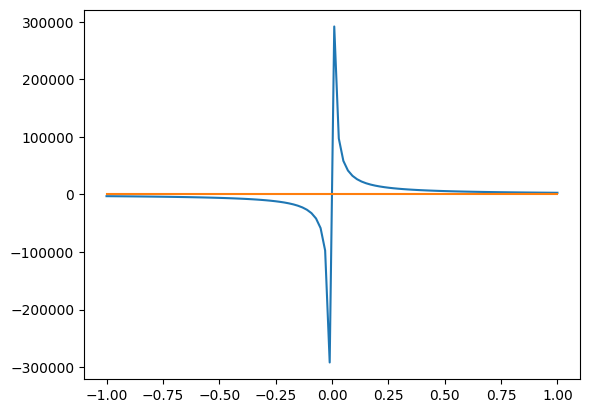

In [213]:
model = Multi_Func_Channels(functions=functions, num_params=num_params, x_data=x_values, input_channels=3, device=device).to(device)

dataloader = DataLoader(full_data, batch_size=100, shuffle=True)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
loss_func = nn.MSELoss()

epochs = 50
for epoch in range(epochs):
    start_time = time.time()
    train_loss = 0.0
    total_num = 1
    model.train()
    
    for batch in dataloader:
        batch = batch.requires_grad_(True).to(device)
        optimizer.zero_grad()
        best_out, best_loss, best_func, preds, losses = model(batch)
        print(best_loss[0])
        print(best_out[0])
        print(batch[0, :, 0])
        loss = training_loss_func(model, best_out, batch[:, :, 0]) #loss_func(best_out, batch[:, :, 0])
        print(f"loss: {loss}")
        plt.plot(x_values.detach().cpu().numpy(), best_out[0, 0:100].detach().cpu().numpy())
        plt.plot(x_values.detach().cpu().numpy(), y_values[0, 0:100].detach().cpu().numpy())
        break
        '''loss.backward()
        optimizer.step()
        train_loss += loss.item() * best_out.shape[0]
        total_num += best_out.shape[0]'''
    break
    '''scheduler.step()
    train_loss /= total_num
    print(f"epoch : {epoch}/{epochs}, loss = {train_loss:.8f}")
    print(f"--- {time.time() - start_time} seconds ---")'''